<a href="https://colab.research.google.com/github/Cepera90/FB/blob/main/FB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
df = pd.read_csv('/content/FB.csv', index_col = 'Дата', parse_dates=True, quotechar='"', decimal=",", dayfirst=True)

In [ ]:
df.head(5)

,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
Дата,,,,,,
2022-01-14,331.90,321.79,332.73,321.21,"16,77M","1,66%"
2022-01-13,326.48,334.98,335.63,325.76,"14,67M","-2,03%"
2022-01-12,333.26,335.18,336.36,330.03,"14,10M","-0,33%"
2022-01-11,334.37,326.78,334.63,325.28,"16,19M","1,92%"
2022-01-10,328.07,325.31,328.34,315.43,"24,83M","-1,12%"


In [2]:
# Sort data ascending by date
df = df.sort_values(by="Дата",
               ascending=True)

In [ ]:
df.head(5)

,Цена,Откр.,Макс.,Мин.,Объём,Изм. %
Дата,,,,,,
2012-05-18,38.23,42.05,45.00,38.00,"580,59M","-57,62%"
2012-05-21,34.03,36.53,36.66,33.00,"168,31M","-10,99%"
2012-05-22,31.00,32.61,33.59,30.94,"102,05M","-8,90%"
2012-05-23,32.00,31.37,32.50,31.36,"73,72M","3,23%"
2012-05-24,33.03,32.95,33.21,31.77,"50,28M","3,22%"


In [3]:
# Prepare data for processing and printing
df['Объём'] = [x.replace(',', '.').replace('M', '') for x in df['Объём']]
df['Изм. %'] = [x.replace('+', '').replace('-', '').replace('%', '').replace(',', '.') for x in df['Изм. %']]
df.loc['2022-01-14':,'Цена':'Изм. %'] = df.loc['2022-01-14':,'Цена':'Изм. %'].astype(float)

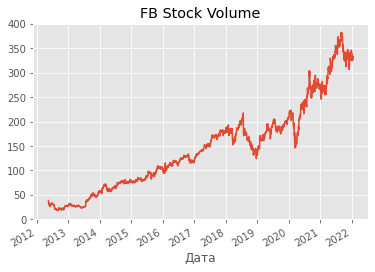

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df['Цена'].plot(label='Цена', title='FB Stock Volume')

In [ ]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0:1]

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

y_array = np.array(y)

In [ ]:
print("X_ss Shape", X_ss.shape)
print("y_mm Shape", y_mm.shape)

X_ss Shape (2433, 5)
y_mm Shape (2433, 1)


In [ ]:
#split dataset to train and test sets
test_size = int(0.1 * len(X_ss))
X_train = X_ss[:-test_size, :]
X_test = X_ss[-test_size:, :]

y_train = y_mm[:-test_size, :]
y_test = y_mm[-test_size:, :]

In [ ]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (2190, 5) (2190, 1)
Testing Shape (243, 5) (243, 1)


In [ ]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [ ]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [ ]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [ ]:
num_epochs = 400 #400 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 64 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

In [ ]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [ ]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.09965
Epoch: 100, loss: 0.00015
Epoch: 200, loss: 0.00003
Epoch: 300, loss: 0.00002


In [ ]:
df_X_ss = ss.transform(df.iloc[:, 1:]) #old transformers
df_y_mm = mm.transform(df.iloc[:, 0:1]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

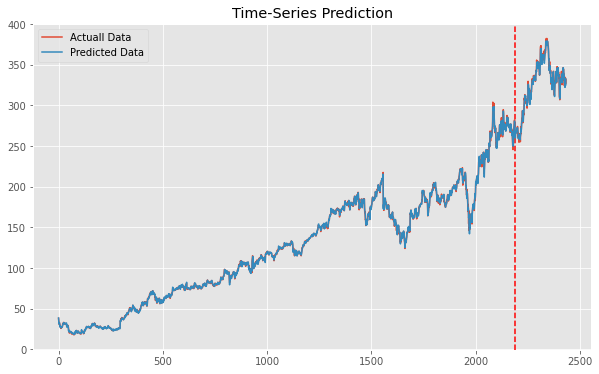

In [ ]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=2190, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()